In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [3]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [4]:
# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image

In [5]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])

# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)

Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
# Load the pre-trained EfficientNetB4 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the lower layers of the pre-trained base
for layer in MobileNetV2_base.layers[:100]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization
# Build the model
model = Sequential()

# Add the pre-trained MobileNetV2 base
model.add(MobileNetV2_base)

# Add Flatten layer (this turns the 2D feature maps into 1D)
model.add(Flatten())

# Add Batch Normalization to normalize the activations
model.add(BatchNormalization())

# Add more Dense layers with more units to increase capacity
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))  # Increase dropout rate to avoid overfitting

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))


# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(8, activation='softmax'))

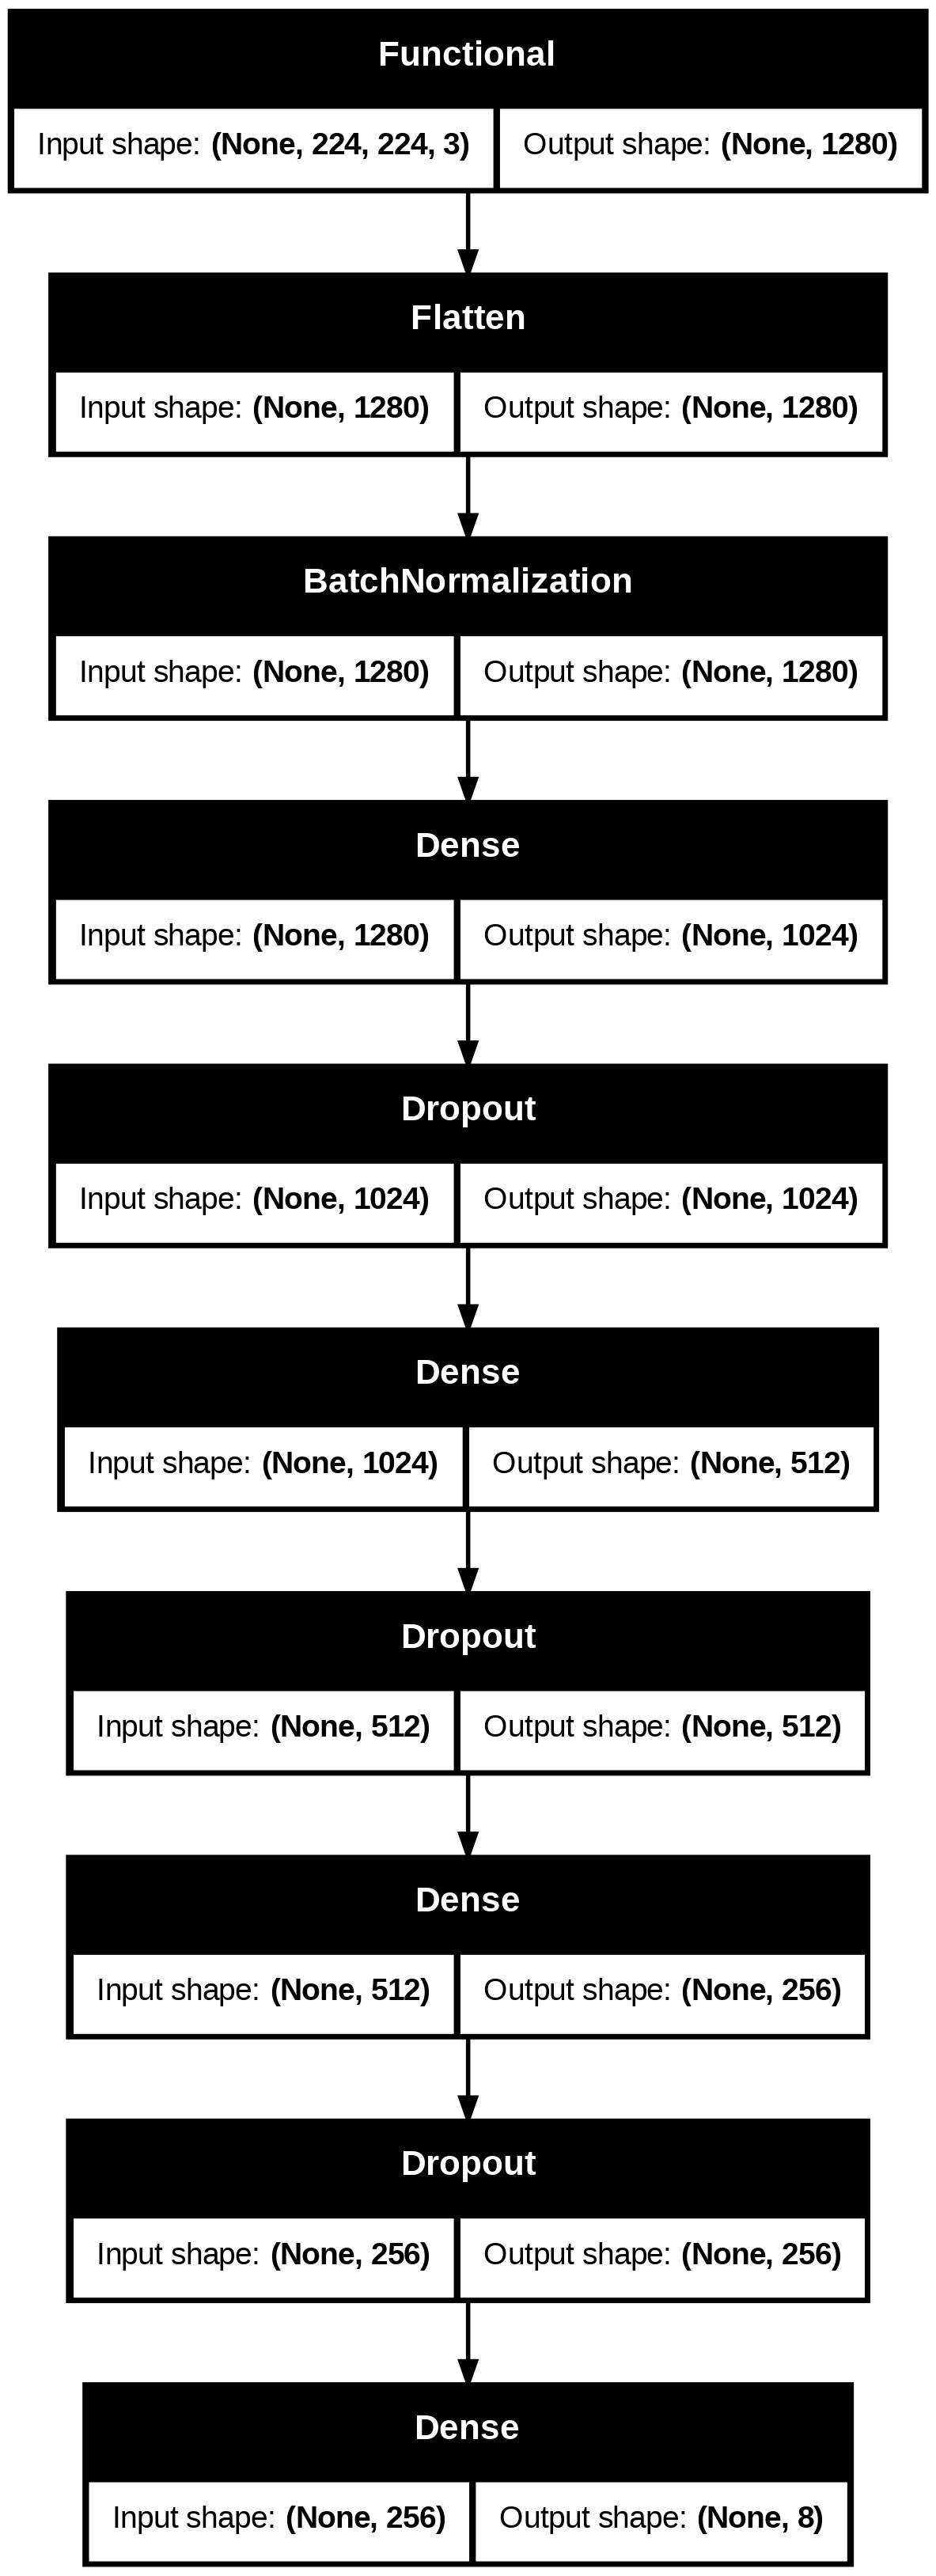

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)


In [35]:
# Model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,233,032 (16.15 MB)

 Trainable params: 3,833,928 (14.63 MB)

 Non-trainable params: 399,104 (1.52 MB)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras import optimizers
import tensorflow as tf

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)  # Best weights'ü geri yükle
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
    callbacks=[early_stopping, reduce_lr]  # Callback'ler
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.2018 - loss: 2.1026 - val_accuracy: 0.2467 - val_loss: 1.9040 - learning_rate: 1.0000e-04
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4172 - loss: 1.6245 - val_accuracy: 0.2097 - val_loss: 1.9014 - learning_rate: 1.0000e-04
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5095 - loss: 1.3476 - val_accuracy: 0.2688 - val_loss: 1.7928 - learning_rate: 1.0000e-04
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5575 - loss: 1.2027 - val_accuracy: 0.2674 - val_loss: 1.8201 - learning_rate: 1.0000e-04
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5845 - loss: 1.1023 - val_accuracy: 0.2954 - val_loss: 1.8478 - learning_rate: 1.0000e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6012 - loss: 1.0392 - val_accuracy: 0.3117 - val_loss: 1.6797 - learning_rate: 1.0000e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy

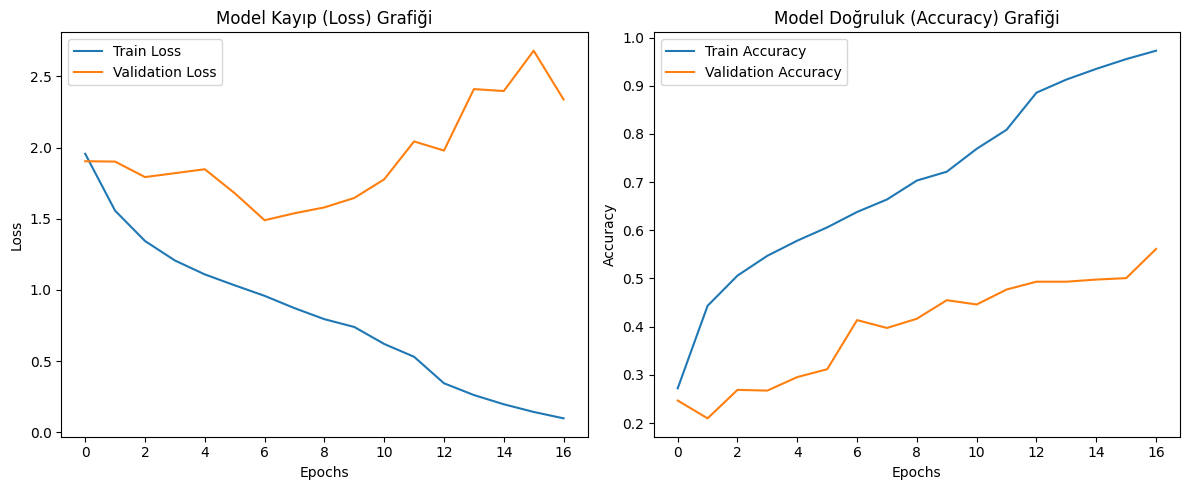

In [41]:
import matplotlib.pyplot as plt
# Kayıp (Loss) ve doğruluk (Accuracy) grafiği
plt.figure(figsize=(12, 5))

# Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Kayıp (Loss) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Grafikleri gösteriyoruz
plt.tight_layout()
plt.show()

Attention

In [11]:
import tensorflow as tf
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor=1, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        
        # Local feature projection
        self.W_l = Conv2D(filters=attn_features, kernel_size=1, padding='same', use_bias=False)
        
        # Global feature projection
        self.W_g = Conv2D(filters=attn_features, kernel_size=1, padding='same', use_bias=False)
        
        # Attention map generation
        self.phi = Conv2D(filters=1, kernel_size=1, padding='same', use_bias=True)
    
    def build(self, input_shape):
        # Ensures the layer builds its variables
        pass

    def call(self, l, g):
        # Ensure g is reshaped to match the dimensions of l
        g = tf.expand_dims(g, axis=1)  # Add height dimension
        g = tf.expand_dims(g, axis=2)  # Add width dimension
        g = tf.tile(g, [1, tf.shape(l)[1], tf.shape(l)[2], 1])  # Broadcast to match spatial dimensions
        
        # Project local and global features
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        
        # Compute attention map
        c = self.phi(tf.nn.relu(l_ + g_))
        
        if self.normalize_attn:
            a = tf.nn.softmax(tf.reshape(c, [tf.shape(c)[0], -1]), axis=-1)
            a = tf.reshape(a, tf.shape(c))
        else:
            a = tf.sigmoid(c)
        
        # Re-weight the local feature
        f = tf.multiply(a, l)
        
        # Compute the weighted sum (global or pooled feature)
        if self.normalize_attn:
            output = tf.reduce_sum(f, axis=[1, 2])  # Weighted sum
        else:
            output = GlobalAveragePooling2D()(f)
        
        return a, output

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
# Model Yapısı
def build_model_with_attention(input_shape=(224, 224, 3), num_classes=8):
    # Base model (feature extractor)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Inputs
    inputs = Input(shape=input_shape)
    
    # Extract features
    x = base_model(inputs)
    
    # Dropout to prevent overfitting
    x = Dropout(0.5)(x)
    
    # Global features (pooled)
    g = GlobalAveragePooling2D()(x)
    
    # Attention Block
    attention_block = AttentionBlock(in_features_l=x.shape[-1], in_features_g=g.shape[-1], attn_features=64)
    attention_map, x = attention_block(x, g)
    
    # Classification Head
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    # Model
    model = Model(inputs, outputs)
    return model

# Model Initialization
model = build_model_with_attention()

# Model Compilation
base_learning_rate = 0.0001
model.compile(
    optimizer=Adam(learning_rate=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 7, 1280)     │              0 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ dropout_1[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_block_1         │ [(None, 7, 7, 1),      │        163,905 │ dropout_1[0][0],       │
│ (AttentionBlock)          │ (None, 1280)]          │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │         10,248 │ attention_block_1[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,432,137 (9.28 MB)

 Trainable params: 2,398,025 (9.15 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras import optimizers
import tensorflow as tf

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)  # Best weights'ü geri yükle
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
    callbacks=[early_stopping, reduce_lr]  # Callback'ler
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 370ms/step - accuracy: 0.2353 - loss: 2.5140 - val_accuracy: 0.1477 - val_loss: 2.5923 - learning_rate: 1.0000e-04
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5015 - loss: 1.5859 - val_accuracy: 0.1773 - val_loss: 2.6277 - learning_rate: 1.0000e-04
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5640 - loss: 1.3602 - val_accuracy: 0.2260 - val_loss: 2.6025 - learning_rate: 1.0000e-04
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6369 - loss: 1.1725 - val_accuracy: 0.2127 - val_loss: 2.5200 - learning_rate: 1.0000e-04
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6655 - loss: 1.0883 - val_accuracy: 0.2157 - val_loss: 2.3339 - learning_rate: 1.0000e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7136 - loss: 0.9898 - val_accuracy: 0.2482 - val_loss: 2.2926 - learning_rate: 1.0000e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy

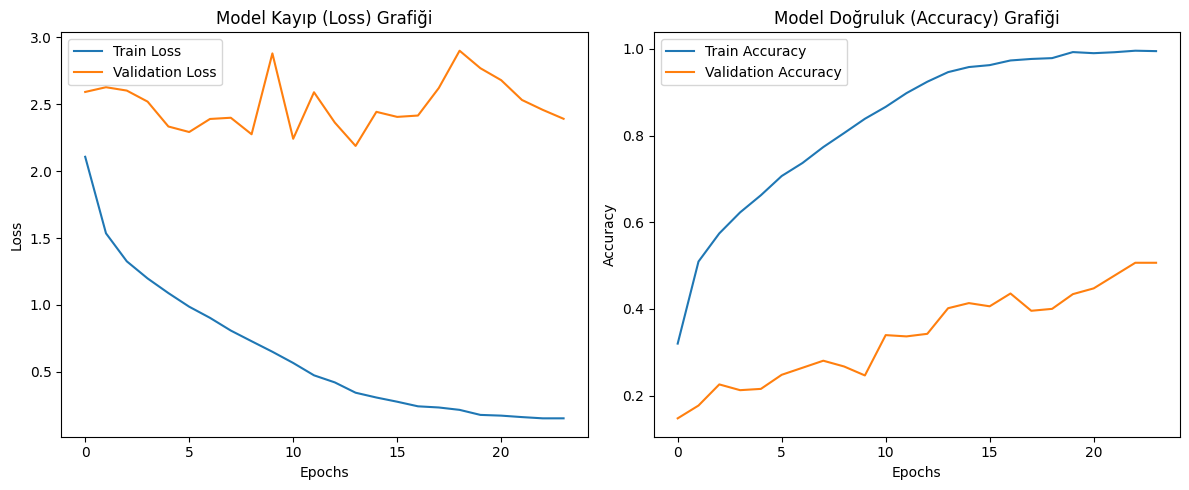

In [14]:
import matplotlib.pyplot as plt
# Kayıp (Loss) ve doğruluk (Accuracy) grafiği
plt.figure(figsize=(12, 5))

# Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Kayıp (Loss) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Grafikleri gösteriyoruz
plt.tight_layout()
plt.show()